1. [Открытие данных](#open_data)
2. [Предобработка данных](#preprocessing_data)
3. [Исследовательский анализ данных](#analyses_of_data)
4. [Объединение таблиц](#merge_tables)
5. [Корреляционный анализ](#corr_analysis)
6. [Использование пайплайнов](#pipelines)
7. [Анализ важности признаков](#shap)
8. [Сегментация покупателей](#segmentation)
9. [Общий вывод](#conclusion)

# Проект "Обучение с учителем: качество модели"


## Описание проекта:
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

### Цели проекта:
Требуется разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

In [1]:
# Код ревьюера
 
# !pip install -U scikit-learn
 

In [2]:
!pip install pandas matplotlib numpy scipy seaborn scikit-learn phik shap category-encoders

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import phik
import shap
import re

# инструменты для разделения выборки и инструменты для автоподбора гиперпараметров
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.inspection import permutation_importance

# загружаем необходимые инструменты для Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score, mean_absolute_error, fbeta_score, mean_squared_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

In [4]:
sns.set_theme(style="darkgrid", palette="dark");
pd.set_option('display.max_columns', None)

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id="open_data"></a> 
## 1. Открытие данных

### 1.1. Данные о поведении покупателя на сайте:

In [6]:
# загрузка данных из файла /datasets/market_file.csv
try:
    market_file = pd.read_csv('datasets/market_file.csv', sep=',')
except:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
market_file.head(5)


In [7]:
# переименование столбцов
market_file.columns = ['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 'Популярная категория', 'Средний просмотр категорий за визит', 'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит']

In [8]:
# вывод общей информации о данных
market_file.info()

Файл `market_file.csv` содержит данные о стаде фермера на текущий момент. Ниже представлено описание каждого признака:

1. **id** — номер покупателя в корпоративной базе данных.
2. **Покупательская активность** — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
3. **Тип сервиса** — уровень сервиса, например «премиум» и «стандарт».
4. **Разрешить сообщать** — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
5. **Маркет актив 6 мес** — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
6. **Маркет актив тек мес** — количество маркетинговых коммуникаций в текущем месяце.
7. **Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
8. **Акционные покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
9. **Популярная категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.
10. **Средний просмотр категорий за визит** — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
11. **Неоплаченные продукты штук квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.
12. **Ошибка сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.
13. **Страниц за визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.



### 1.2. Данные о выручке с покупателя:

In [9]:
# загрузка данных из файла /datasets/market_money.csv
try:
    market_money = pd.read_csv('datasets/market_money.csv', sep=',')
except:
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
market_money.head(5)


In [10]:
# вывод общей информации о данных
market_money.info()

Файл `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

1. **id** — номер покупателя в корпоративной базе данных.
2. **Период** — название периода, во время которого зафиксирована выручка. Например,
'текущий_месяц' или 'предыдущий_месяц'.
3. **Выручка** — сумма выручки за период.

### 1.3. Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

In [11]:
# загрузка данных из файла /datasets/market_time.csv
try:
    market_time = pd.read_csv('datasets/market_time.csv', sep=',')
except:
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
market_time.head(5)


In [12]:
# переименование столбцов
market_time.columns = ['id', 'Период', 'Минут']

In [13]:
# вывод общей информации о данных
market_time.info()

Файл `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

1. **id** — номер покупателя в корпоративной базе данных.
2. **Период** — название периода, во время которого зафиксировано общее время.
3. **Минут** — значение времени, проведённого на сайте, в минутах.

### 1.4. Данные о среднемесячной прибыли покупателя:

In [14]:
# загрузка данных из файла /datasets/money.csv
try:
    money = pd.read_csv('datasets/money.csv', sep=';')
except:
    money = pd.read_csv('/datasets/money.csv', sep=';')
money.head(5)


In [15]:
# вывод общей информации о данных
money.info()

Файл `money.csv` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

1. **id** — номер покупателя в корпоративной базе данных.
2. **Прибыль** — значение прибыли.

### 1.5. Вывод по шагу "Загрузка данных"
- Данные загружены, названия столбцов переименованы, общая информация о данных выведена.
- Прочитаны данные о 1300 пользователях сайта.
- Множество некорректных тип данных наблюдается во всех трех таблицах.

<a id="preprocessing_data"></a> 
## 2. Предобработка данных

#### 2.1. **market_file** изучение и исправление ошибок:


In [16]:
market_file.info()

In [17]:
market_file.columns = [i.replace(' ', '_').lower() for i in market_file.columns]

In [18]:
market_file.columns

Названия колонок приведены к змеиному виду

In [19]:
print('Количество дубликатов:', market_file.duplicated().sum())

In [20]:
market_file.describe()

In [21]:
market_file.sample(10)

In [22]:
columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for column in columns:
    print(f'{column}: {market_file[column].unique()}')

Приведу к нижнему регистру и исправлю ошибки:

In [23]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.lower()
market_file['популярная_категория'] = market_file['популярная_категория'].str.lower()

#### 2.2. **market_money** изучение и исправление ошибок:

In [24]:
market_money.info()

In [25]:
market_money.columns = [i.replace(' ', '_').lower() for i in market_money.columns]

Названия колонок приведены к змеиному виду 

In [26]:
print('Количество дубликатов:', market_money.duplicated().sum())

In [27]:
market_money.describe()

In [28]:
market_money.sample(10)

In [29]:
columns = ['период']
for column in columns:
    print(f'{column}: {market_money[column].unique()}')

Исправлю ошибки:

In [30]:
market_money['период'] = market_money['период']\
    .str.replace('препредыдущий_месяц', 'препредыдущий месяц')\
    .str.replace('текущий_месяц', 'текущий месяц')\
    .str.replace('предыдущий_месяц', 'предыдущий месяц')

#### **2.3. market_time** изучение и исправление ошибок:

In [31]:
market_time.info()

In [32]:
market_time.columns = [i.replace(' ', '_').lower() for i in market_time.columns]

In [33]:
print('Количество дубликатов:', market_time.duplicated().sum())

In [34]:
market_time.describe()

In [35]:
market_time.sample(10)

In [36]:
columns = ['период']
for column in columns:
    print(f'{column}: {market_time[column].unique()}')

Исправлю ошибки:

In [37]:
market_time['период'] = market_time['период']\
    .str.replace('текущий_месяц', 'текущий месяц')\
    .str.replace('предыдцщий_месяц', 'предыдущий месяц')

#### 2.4 **money** поиск и исправление ошибок:

In [38]:
money.info()

In [39]:
money.columns = [i.replace(' ', '_').lower() for i in money.columns]

Колонки приведены к змеиному виду

In [40]:
print('Количество дубликатов:', money.duplicated().sum())

In [41]:
money.describe()

In [42]:
money.sample(10)

In [43]:
money['прибыль'] = money['прибыль'].str.replace(',', '.').astype('float')

In [44]:
money.describe()

Формат признака "Прибыль" исправлен со строки на плавающий с запятой.


#### 2.5. Вывод по шагу "Предобработка данных"

Были изучены признаки таблиц:
- исправлены типы данных
- исправлены ошибки написания
- значения приведены к одному типу где требовалось

<a id="analyses_of_data"></a> 
## 3. Исследовательский анализ данных

In [45]:
# создание функции для get_boxplot, get_histplot, get_countplot
def get_histplot(df, palette='dark'):
    sns.set_theme(style="darkgrid", palette=palette);
    for col in df.drop('id', axis=1).select_dtypes(include=['float64', 'int64']):
        plt.figure(figsize=(8, 3))
        sns.histplot(df[col], kde=True)
        plt.title(f'Распределение: {col}')
        plt.ylabel('Частота')
        plt.grid(True)
        plt.show()

def get_countplot(df, palette='dark'):
    sns.set_theme(style="darkgrid", palette=palette);
    for col in df.select_dtypes(include=['object']):
        plt.figure(figsize=(12, 3))
        sns.countplot(x=col, data=df)
        plt.title(f'Категория: {col}')
        plt.ylabel('Частота')
        plt.show()

def get_boxplot(df, palette='dark'):
    sns.set_theme(style="darkgrid", palette=palette);
    for col in df.drop('id', axis=1).select_dtypes(include=['float64', 'int64']):
        plt.figure(figsize=(8, 3))
        sns.boxplot(x=df[col])
        plt.title(f'Боксплот: {col}')
        plt.show()

### 3.1 **market_file** гистрограмма, боксплот, каунтплот

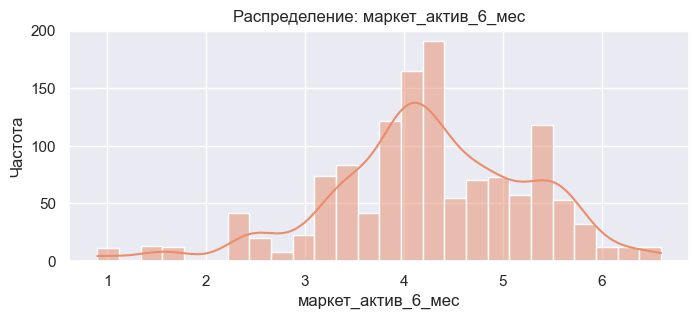

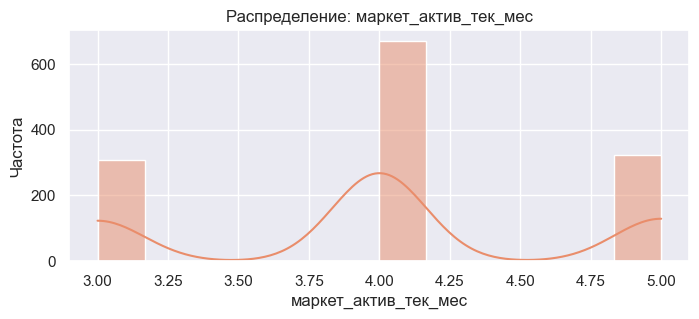

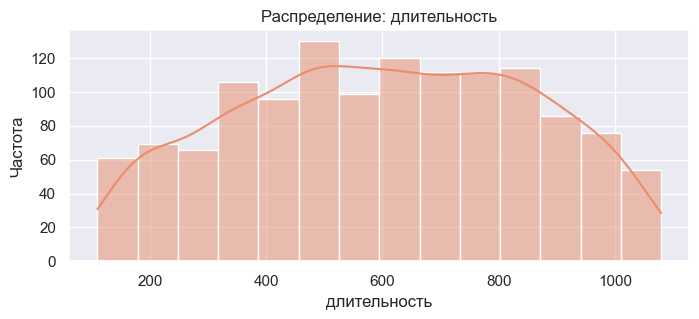

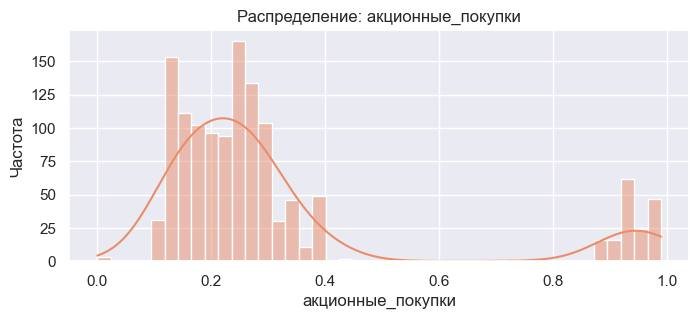

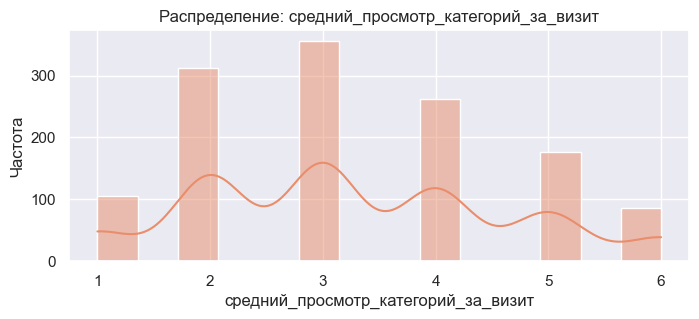

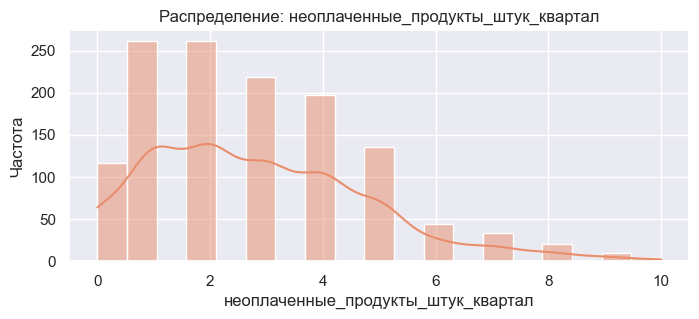

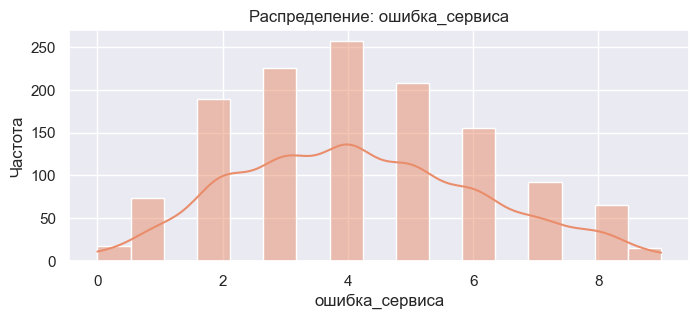

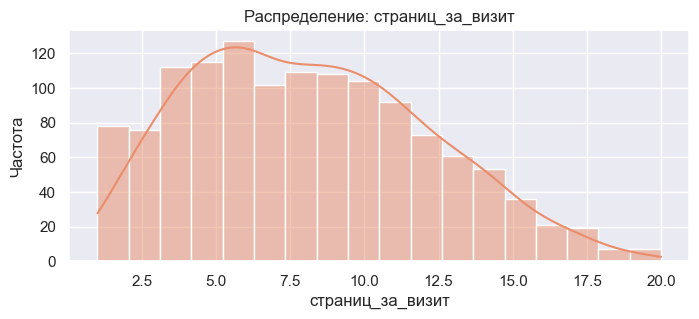

In [46]:
# построение гистограмм для числовых данных
get_histplot(market_file, "flare")

Анализ гистограм на данных **market_file**
1. **Маркет актив 6 мес**: нормальное распределение, смещено влево, есть пик на значении 4
2. **Маркет актив тек мес**: нормальное распределение, без смещения, пик на значении 4
3. **Длительность**: нормальное распределение, без смещения, есть пик на 500, возможно в то время была высокая маркетинговая деятельность
4. **Акционные покупки**: выделяются две группы пользователей - одна покупает умеренное количество товаров на акциях, другая покупает преимущественно по акциям
5. **Средний просмотр категорий за визит**: нормальное распределение, смещение вправо, пик на значении 3
6. **Неоплаченные продукты штук квартал**: нормальное распределение, смещено вправо, большинство значений приходится на 1-2 штуки
7. **Ошибка сервиса**: нормальное распределение, мода на значении 4
8. **Страниц за визит**: нормальное распределение, смещено вправо, мода находится на значении 5.5

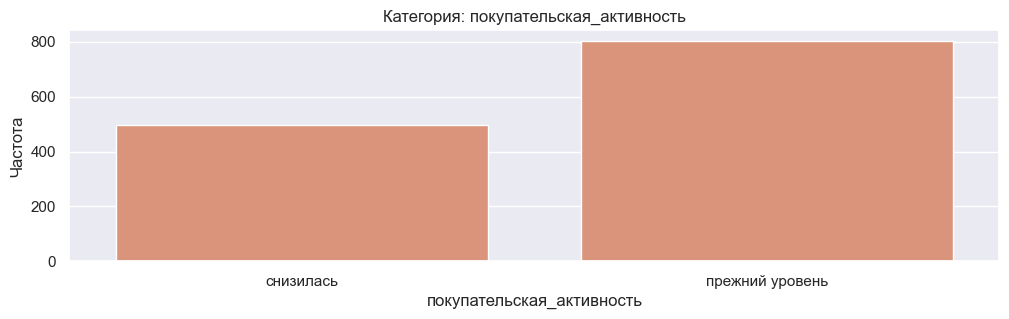

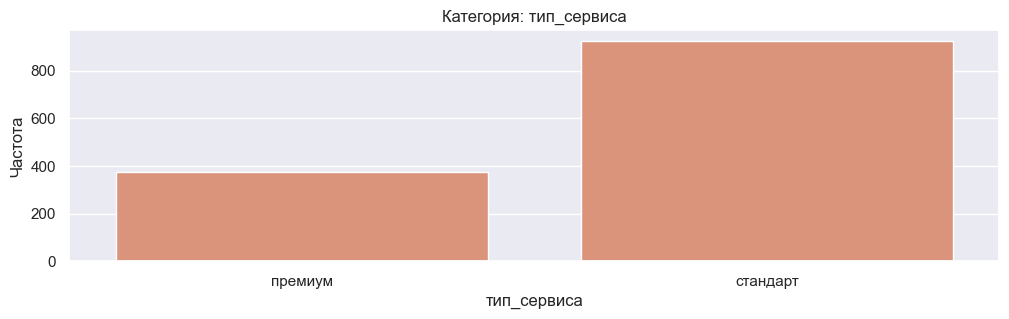

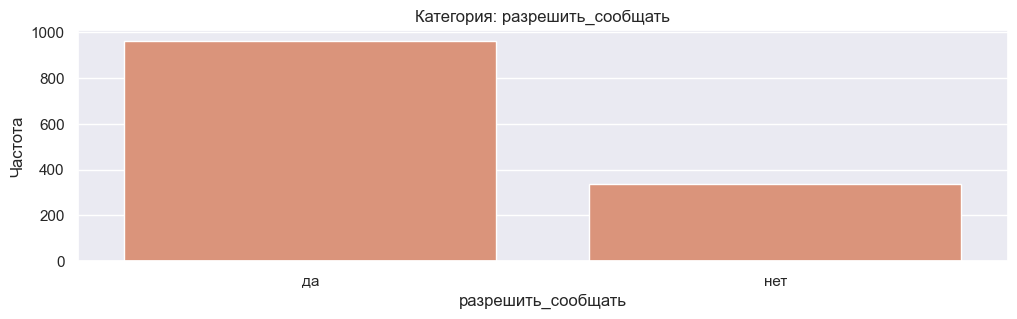

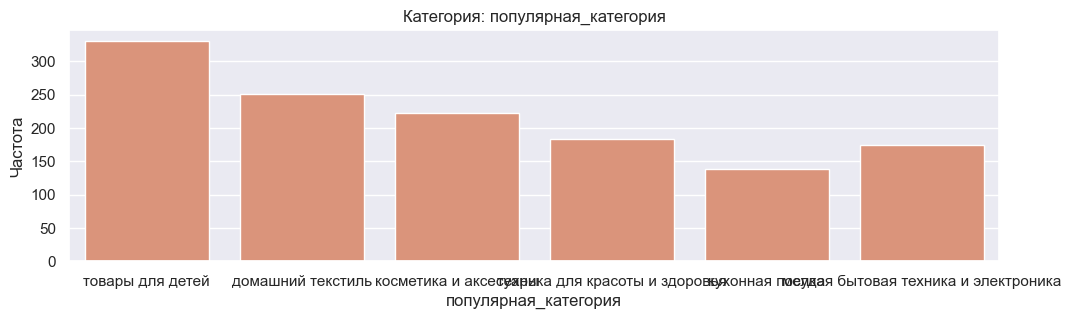

In [47]:
get_countplot(market_file, 'flare')

Анализ категоривальных данных:
1. **Покупательская активность**: большинство пользователей сохранили покупательскую активность, но есть большое количество пользователей со сниженной активностью
2. **Тип сервиса**: большинство пользуются "стандарт", чуть меньше 400ха на "премиум"
3. **Разрешить сообщать**: большинство пользователей разрешили доставку
4. **Популярная категория**: самая популярная категория "Товары для детей", самая непопулярная "Кухонная посуда"

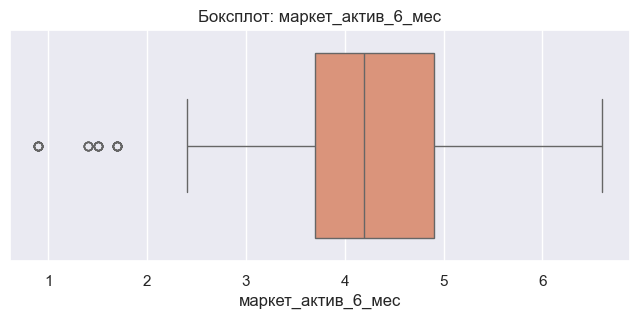

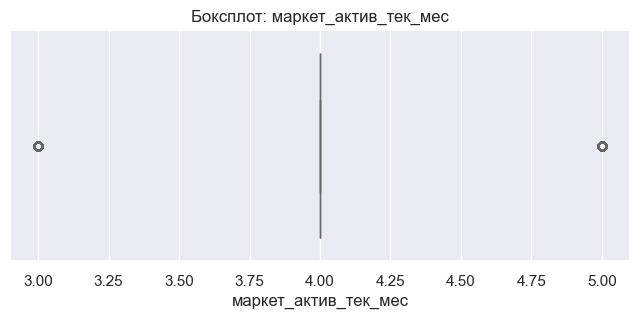

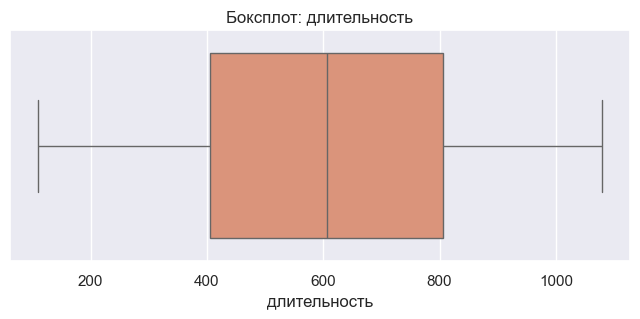

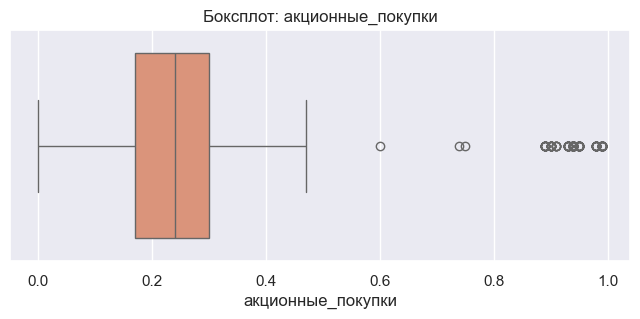

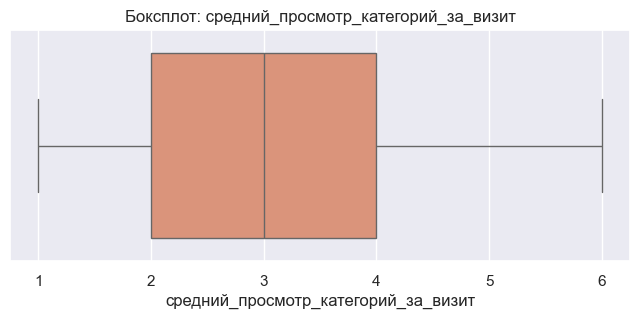

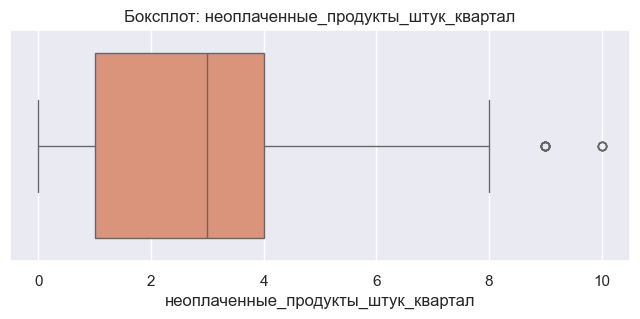

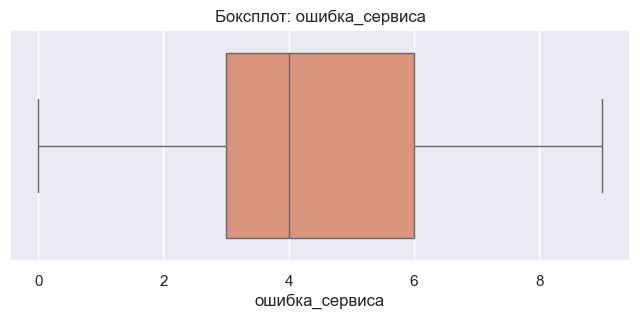

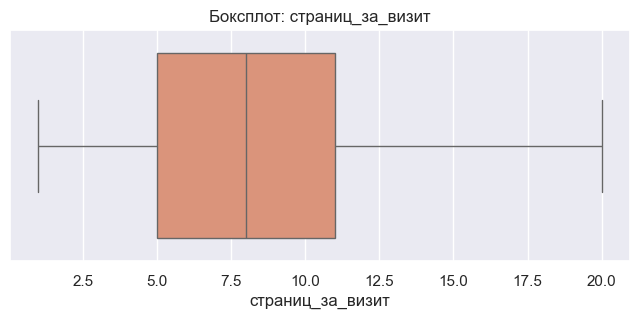

In [48]:
get_boxplot(market_file, 'flare')

Анализ боксплотов на данных **market_file**
1. **Маркет актив 6 мес**: 50% значений входят в 3.8 до 4.9, медиана на 4.2
2. **Маркет актив тек мес**: 50% значений входят в 4, медиана на 4
3. **Длительность**: 50% значений входят в 400 до 800, медиана на 600
4. **Акционные покупки**: 50% значений входят в 0.18 до 0.3, медиана на 0.22
5. **Средний просмотр категорий за визит**: 50% значений входят в 2 до 4, медиана на 3
6. **Неоплаченные продукты штук квартал**: 50% значений входят в 1 до 4, медиана на 3
7. **Ошибка сервиса**: 50% значений входят в 3 до 6, медиана на 4
8. **Страниц за визит**: 50% значений входят в 5 до 1, медиана на 8

### 3.2 **market_money** гистрограмма, боксплот, каунтплот

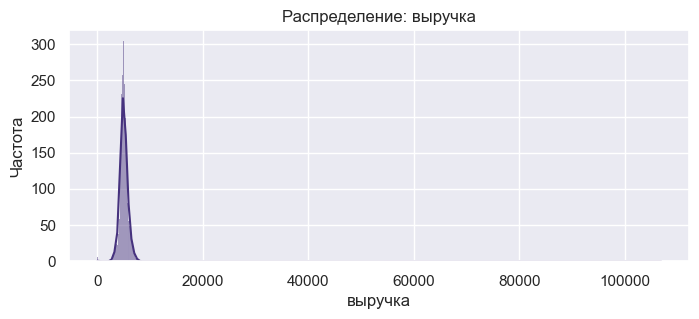

In [49]:
get_histplot(market_money, 'viridis')

Обнаружился выброс, устраняю

In [50]:
print('До удаления выбросов:', market_money.shape[0])

In [51]:
# поиск
users_to_drop = market_money.query('выручка > 50000')['id'].tolist()
print(users_to_drop)

In [52]:
# проверка юзера с аномальным значением
market_money[market_money['id'] == users_to_drop[0]]

In [53]:
# удаление
market_money = market_money[market_money['id'] != users_to_drop[0]]
print('После удаления выбросов:', market_money.shape[0])


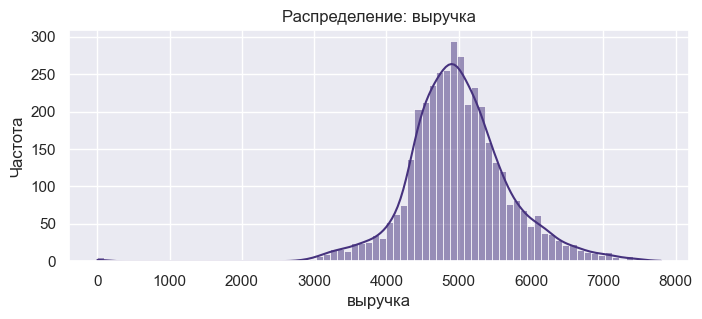

In [54]:
get_histplot(market_money, 'viridis')

Анализ гистограммы для **market_money**:
- **Выручка**: распределение нормальное, мода на значении 5000

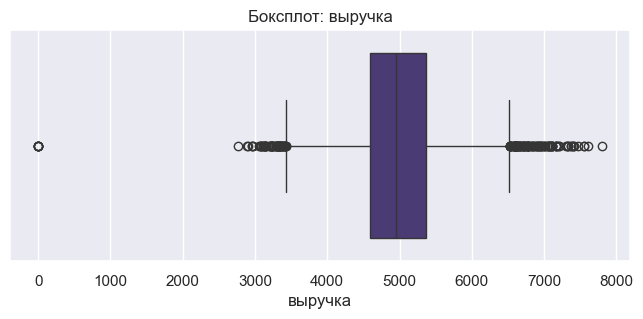

In [55]:
get_boxplot(market_money, 'viridis')

Анализ боксплота для значений **market_money**:
- **Выручка**: 50% значений находятся в диапазоне 4500-5500, медиана на значении 5000

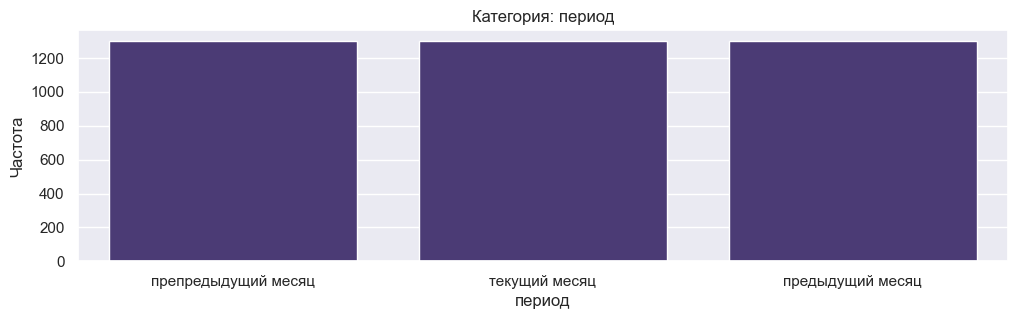

In [56]:
get_countplot(market_money, 'viridis')

Анализ каунтплота для значений **market_money**:
- **Период**: у нас равное количество пользователей во всех трех периодах

### 3.3 **market_time** гистрограмма, боксплот, каунтплот

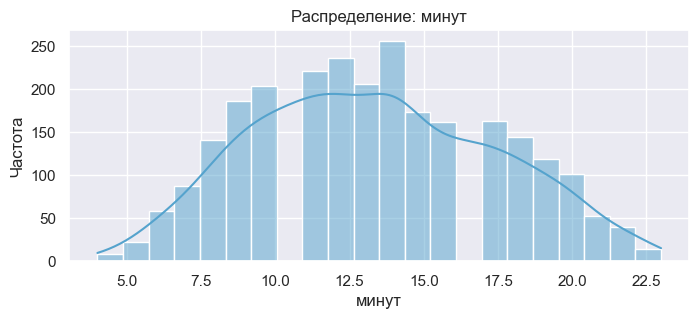

In [57]:
get_histplot(market_time, 'icefire')

Анализ гистограммы для данных **market_time**:
- **Минут**: распределение нормальное, пик на 14ти минутах

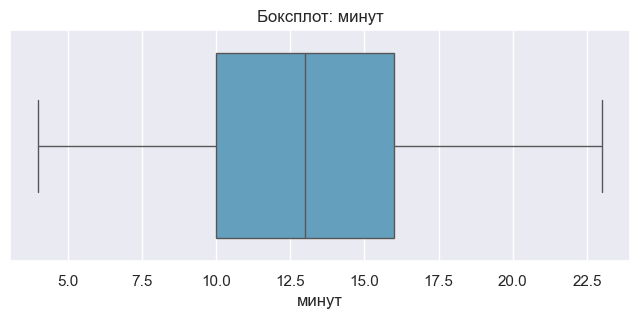

In [58]:
get_boxplot(market_time, 'icefire')

Анализ боксплота для данных **market_time**:
- **Минут**: 50% значений находятся в диапазоне 10-16 минут, медиана на 13 минутах

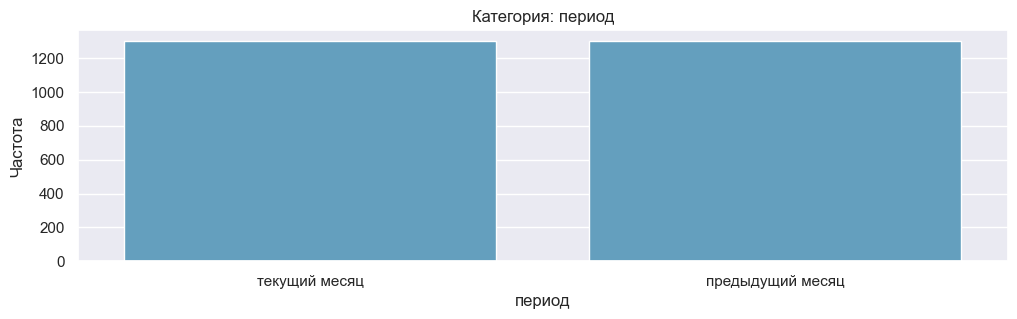

In [59]:
get_countplot(market_time, 'icefire')

Анализ каунтплота для данных **market_time**:
- **Минут**: равное количество пользователей для текущего и предыдущего месяца

### 3.4 **money** гистрограмма, боксплот

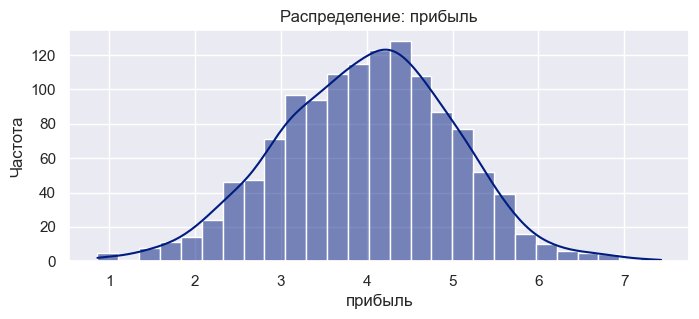

In [60]:
get_histplot(money)

Анализ гистограммы для данных **money**:
- **Прибыль**: распределение нормальное, мода на значении 4.5

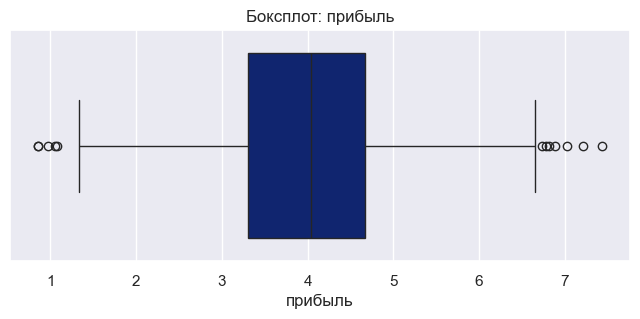

In [61]:
get_boxplot(money)

Анализ боксплота для данных **money**:
- **Прибыль**: 50% значений в диапазоне 3.3-4.8, медиана на значении 4

#### 3.5 Вывод по исследовательскому анализу данных
- Данные собраны равномерно по периодам
- Количество пользователей с падающей покупательской способностью около 500 из 1300 представленных
- Большинство пользователей лояльны сервису и разрешили сообщать об акциях
- Выделяются две группы пользователей по проценту акционных покупок, которые периодически покупают товары по акциям и которые покупают исключительно по акциям
- Большинство пользователей достаточно активны и просматривают от 3 категории за визит
- Медианна выручка с пользователей 5000
- Пользователи проводят в среднем 13 минут на сайте

<a id="merge_tables"></a> 
## 4. Объединение таблиц

In [62]:
market_file.columns

In [63]:
# создание новых фич для данных
try:
    market_time['текущий_месяц_минут'] = market_time.query('период == "текущий месяц"')[['минут']]
    market_time['предыдущий_месяц_минут'] = market_time.query('период == "предыдущий месяц"')[['минут']]
    market_time = market_time.drop('период', axis=1).drop('минут', axis=1)
except:
    print('Данные были обработаны ранее')

# "схлопываю" данные, чтобы одна строка содержала всю информацию
market_time = market_time.groupby('id').agg('first')

# смотрю результат
market_time.sample(10)

In [64]:

# создание новых фич для данных
try:
    market_money['препредыдущий_месяц_выручка'] = market_money.query('период == "препредыдущий месяц"')[['выручка']]
    market_money['текущий_месяц_выручка'] = market_money.query('период == "текущий месяц"')[['выручка']]
    market_money['предыдущий_месяц_выручка'] = market_money.query('период == "предыдущий месяц"')[['выручка']]
    market_money = market_money.drop('период', axis=1).drop('выручка', axis=1)
except:
    print('Данные были обработаны ранее')

# "схлопываю" данные, чтобы одна строка содержала всю информацию
market_money = market_money.groupby('id').agg('first')

# смотрю результат
market_money.sort_values(by='id').head(10)

#### Выполним условие задания: убрать клиентов которые не проявили активность хотя бы в одном из 3 месяцев:

In [65]:
market_money = market_money.query('препредыдущий_месяц_выручка > 0 and текущий_месяц_выручка > 0 and предыдущий_месяц_выручка > 0')

Убираем таких пользователей, у которых были месяцы без покупок

In [66]:
print('Из 1300 юзеров осталось:', market_money.shape[0])

In [67]:
df = market_file.merge(market_time, on='id').merge(market_money, on='id')

In [68]:
# проверяем конечную размерность таблицы
df.shape

In [69]:
# посмотрим на результат
df.sample(3)

Вывод по объединению данных:
- Были созданы дополнительные колонки по периодам
- Данные "схлопнули", теперь одна строка - один юзер - содержит всю необходимую информацию
- Покупатели с месяцами без сделок были отфильтрованы, чтобы не увести нашу модель от поиска закономерностей (1000 рублей за месяц и 0 это значительная разница)
- Выбросы были устранены
- Все проверки были сделаны

<a id="corr_analysis"></a> 
## 5. Корреляционный анализ

### 5.1 Изучение линейных взаимосвязей:

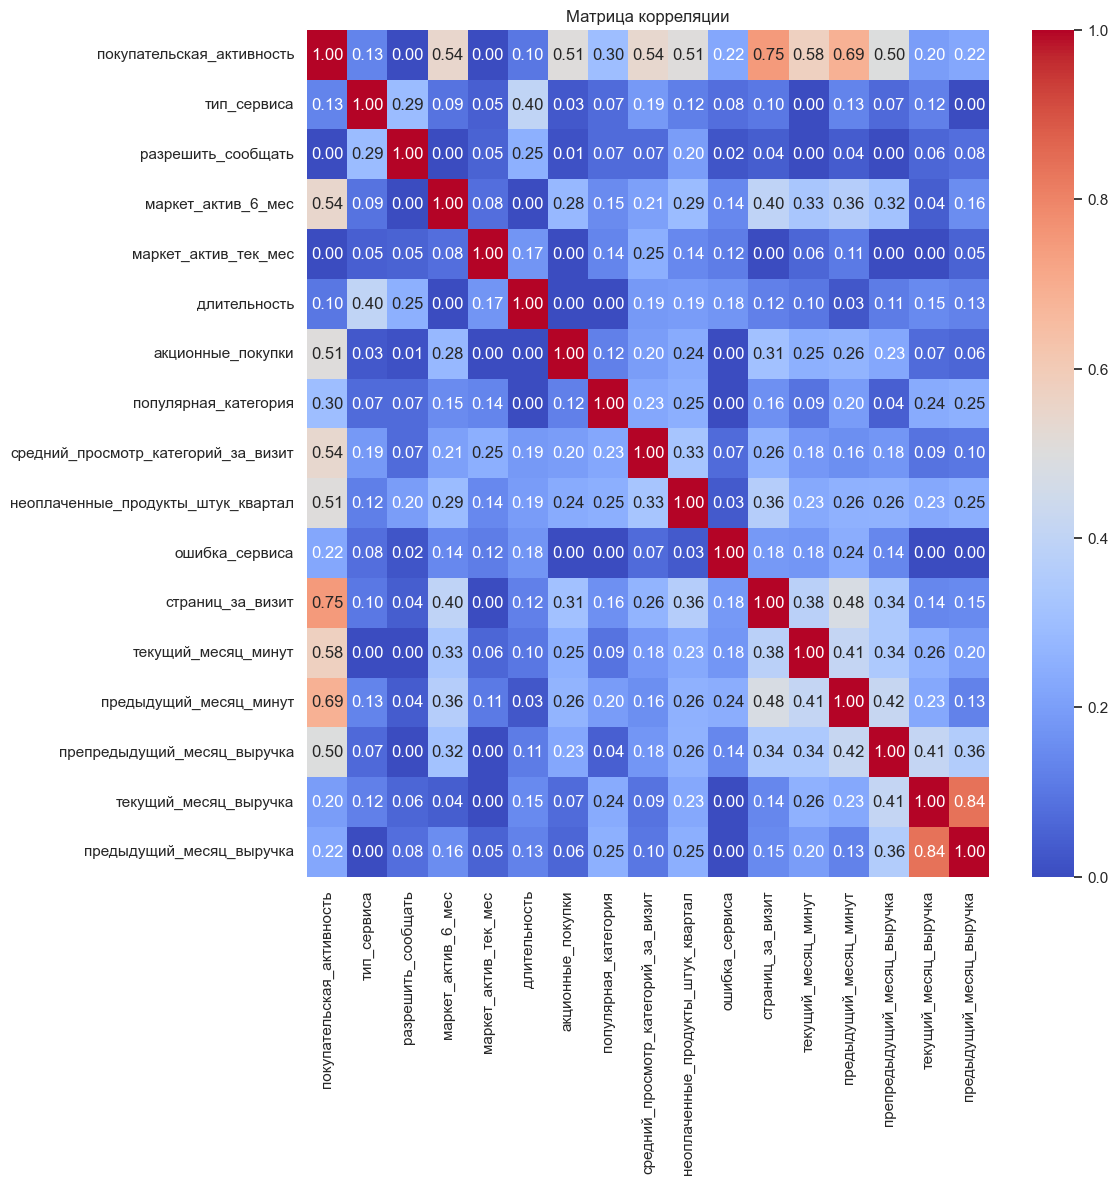

In [70]:
matrix = df.drop('id', axis=1).phik_matrix()
plt.figure(figsize=(11, 11))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Наблюдается сильная положительная корреляция (0.70+) между признаками:
- Покупательская активность и Страниц за визит.
- Акционные покупки и Предыдущий месяц выручка
- Препредыдущий месяц выручка и Предыдущий месяц выручка

Умеренная положительная корреляция (0.50 - 0.70) между признаками:
- Покупательская активность и Предыдущий месяц минут
- Акционные покупки и Предыдущий месяц выручка
- Покупательская активность и Текущий месяц минут
- Покупательская активность и Маркет актив 6 месяц
- Покупательская активность и Средний просмотр категорий за визит
- Покупательская активность и Акционные покупки

Покупательская активность имеет положительную корреляцию с множеством параметров.
На нее хорошо влияют акции, рекламные кампании, высокая активность пользователя на сайте.


Корреляция между Покупательская активность и Страниц за визит самая высокая, однако это скорее похожие зависимые метрики от общей заинтересованности человека.
Хороший юзер интерфейс может положительно влиять на активность (например заметил что-то интересное в предложенном или увидел неожиданно хорошую цену среди товаров).

Есть положительная корреляция между Страниц за визит и:
- Маркет актив 6 мес - активные рекламные кампании увеличивают интерес
- Акционные покупки - хорошии акции тоже увеличивают интерес
- Неоплаченные продукты штук - товары попали в корзину, но не были оплачены
- Предыдущий месяц минут - больше времени на сайте - больше страниц - больше покупательская активность

Мультиколлинеарных признаков не обнаружено. Признаков с корреляцией 0.8+ не обнаружены. Признаки с корреляцией в 75 выглядят правдоподобно:
- Страниц за визит имеет высокую положительную корреляцию с Покупательской активностью, но это выглядит логично.




<a id="pipelines"></a> 
## 6. Использование пайплайнов

In [71]:
target = 'покупательская_активность'
df[target] = df[target].apply(lambda x: 1 if x == 'снизилась' else 0 if x == 'прежний уровень' else x)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target, 'id'], axis=1),
    df[target],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df[target])

# проверка размерности
X_train.shape, X_test.shape

In [72]:
# проверка результата изменения признаков
X_train.columns

In [73]:
# проверка преобразования к числовым параметрам
y_train.sample(3)

In [ ]:
ord_columns = ['тип_сервиса']
ohe_columns = ['разрешить_сообщать']
tae_columns = ['популярная_категория']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'текущий_месяц_минут', 'предыдущий_месяц_минут', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_выручка']



# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder(categories=[
                    ['стандарт', 'премиум']
                ],handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

tae_pipe = Pipeline([
    ('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('tae', tae_pipe, tae_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': range(1, 5),
        'models__kernel': ['linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Вывод по шагу "Использование пайплайнов":

- 'прежний уровень' выбран как 1, 'понизилась' выбран как 0
- данные были подготовлены используя пайплайн и необходимые инструменты
- были выбраны 4 моделидля обучения: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC
- были подобраны соответствующие гиперпараметры для моделей 
- т.к. мы хотим определить понижение покупательской активности - была выбрана метрика "recall"

Модель LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear') оказалась лучшей.
- Метрика лучшей модели на тренировочной выборке: 0.90
- Метрика ROC-AUC (бета = 10) на тестовой выборке: 0.91

Метрика roc-auc была выбрана для обучения и оценки модели, так как она позволяет эффективно сравнимать множество моделей между друг другом. Эта метрика более устойчивая к имбалансным данным. Roc-auc учитывает все возможные пороги. Также ее легко оценить (порог в 0.5 говорит про 50% шанс ошибки, выше значение - ниже ошибка).

<a id="shap"></a> 
## 7. Анализ важности признаков

### 7.1 Оценка важности признаков и построение графика SHAP

Шаг первый, анализ предсказанной модели

In [75]:
# `randomized_search` определила лучшую модель
best_model = randomized_search.best_estimator_

X_train = best_model.named_steps['preprocessor'].transform(X_train)
X_test = best_model.named_steps['preprocessor'].transform(X_test)

In [76]:
poly = PolynomialFeatures(2)
selector = SelectKBest(f_classif, k=16)
scaler = StandardScaler()
model = randomized_search.best_estimator_.named_steps['models']

Подготовлена модель

In [77]:
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [78]:
# стандартизируем признаки
X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train),columns = poly.get_feature_names_out())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test),columns = poly.get_feature_names_out())

# обучаем SelectKBest
selector.fit(X_train_scalled, y_train)

# сформируйте выборки с лучшими признаками
features_names = X_train_scalled.columns[selector.get_support(indices=True)]
X_train_new = X_train_scalled[list(features_names)]
X_test_new = X_test_scalled[list(features_names)]

Сформированы выборки, готовы данные для обучения

In [79]:
# обучите модель на лучших признаках
model.fit(X_train_new, y_train)
print(list(features_names))

In [80]:
# узнаем названия колонок для последующего анализа
print(best_model.named_steps['preprocessor'].get_feature_names_out())

Оригинальные названия колонок:
- x0 - тип_сервиса_стандарт
- x1 - разрешить_сообщать_нет
- x2 - популярная_категория
- x3 - маркет_актив_6_мес
- x4 - маркет_актив_тек_мес
- x5 - длительность
- x6 - акционные_покупки
- x7 - средний_просмотр_категорий_за_визит
- x8 - неоплаченные_продукты_штук_квартал
- x9 - ошибка_сервиса
- x10 - страниц_за_визит
- x11 - текущий_месяц_минут
- x12 - предыдущий_месяц_минут
- x13 - препредыдущий_месяц_выручка
- x14 - текущий_месяц_выручка
- x15 - предыдущий_месяц_выручка

In [81]:
features_names = [
    'маркет_актив_6_мес',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'страниц_за_визит',
    'текущий_месяц_минут',
    'предыдущий_месяц_минут',
    'препредыдущий_месяц_выручка',
    'тип_сервиса_стандарт акционные_покупки',
    'тип_сервиса_стандарт неоплаченные_продукты_штук_квартал',
    'тип_сервиса_стандарт страниц_за_визит',
    'тип_сервиса_стандарт предыдущий_месяц_минут',
    'популярная_категория акционные_покупки',
    'популярная_категория страниц_за_визит',
    'популярная_категория текущий_месяц_минут',
    'популярная_категория предыдущий_месяц_минут'
]

Вывод названий признаков

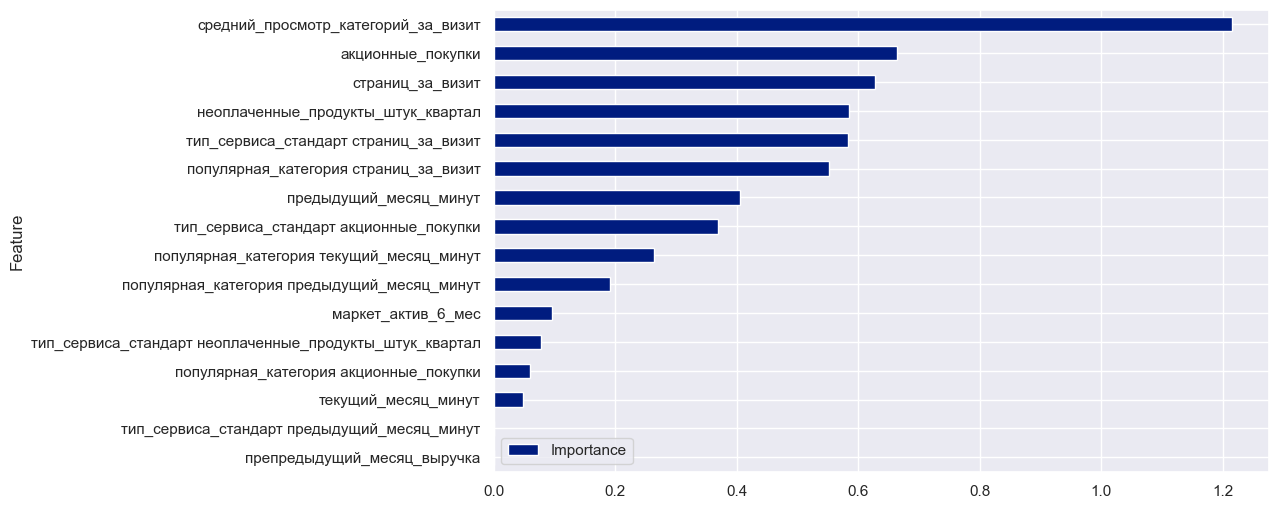

In [82]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Построение первого графика, отображающего важность признаков

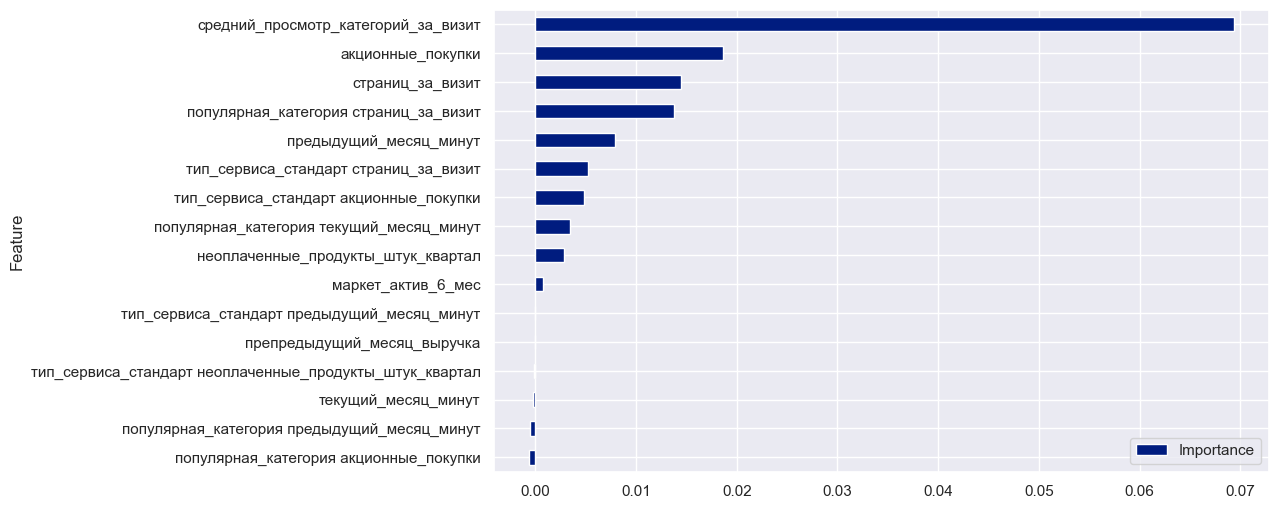

In [83]:
# второй способ определения значимости признаков
result = permutation_importance(model, X_test_new, y_test, scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [84]:
X_test_new.columns = features_names

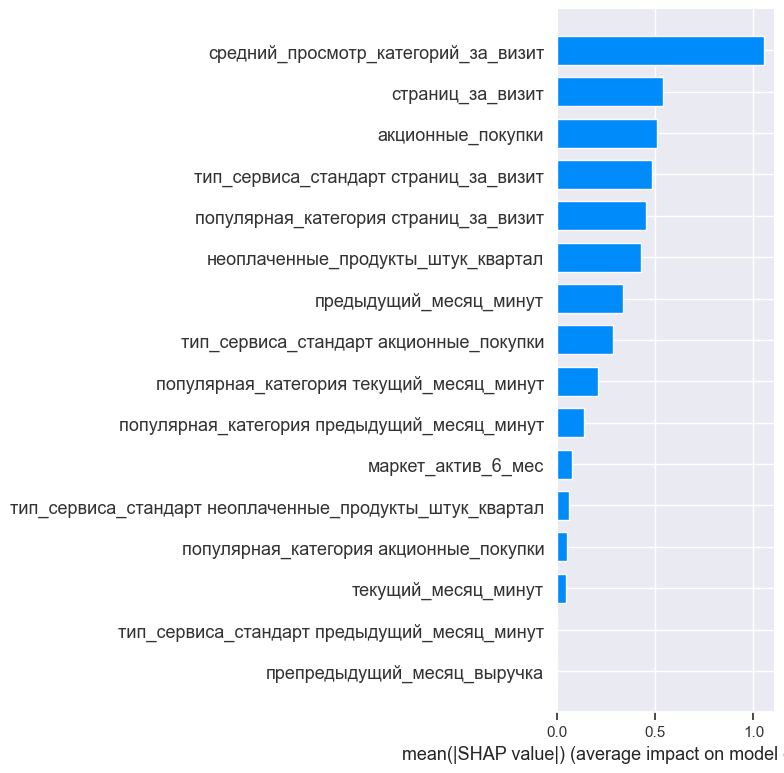

In [85]:
# используем метод shap для подготовки "explainer", который поможет строить графики
explainer = shap.LinearExplainer(model, X_test_new)
shap_values = explainer(X_test_new)

# строим график важности признаков
shap.summary_plot(shap_values, max_display=17, plot_type='bar')

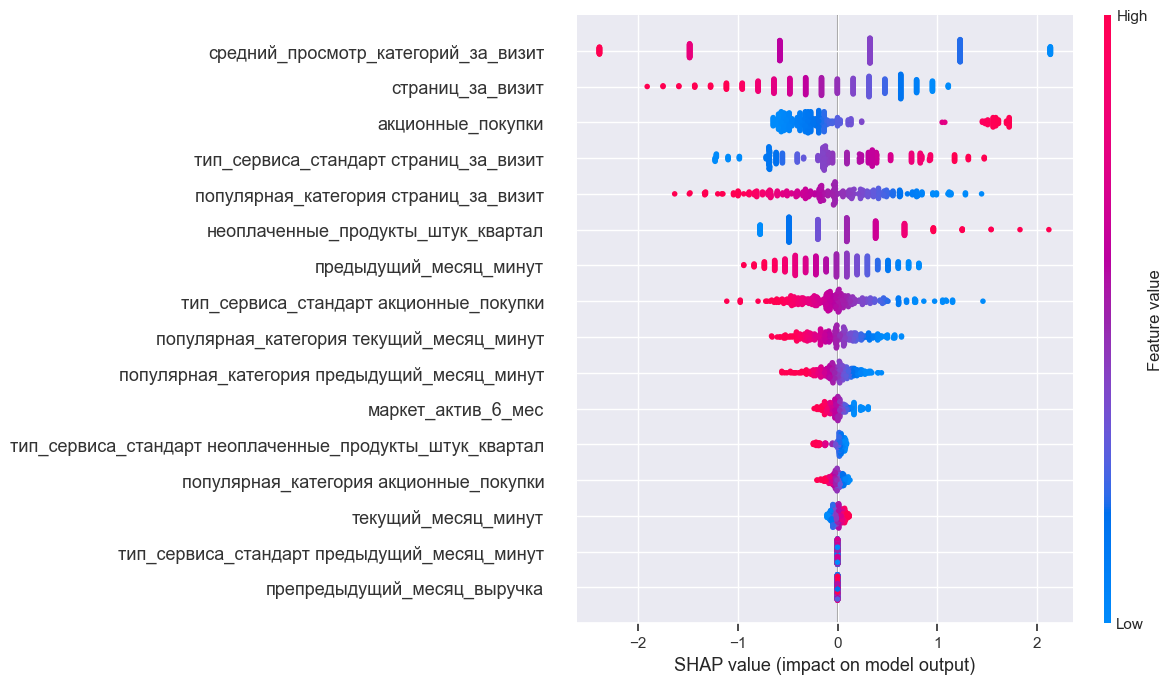

In [86]:
# строим еще один популярный график важности признаков
shap.plots.beeswarm(shap_values, max_display=16)


**Основные признаки с наибольшим влиянием:**

Красные точки - высокие значения, синие точки - низкие значения. Точка справа на оси - признак оказывает положительное влияние на предсказание класса, точка слева на оси - признак оказывает отрицательное влияние на предсказание класса.

Средний_просмотр_категорий_за_визит:
- Красные точки (высокие значения) находятся слева, синие (низкие значения) - справа. Это можно интерпретировать как "большее количество просмотренных категорий уменьшает вероятность класса 1 - уменьшает вероятность снижения активности".
- Синие точки (низкие значения) находятся справа, и они наоборот увеличивают вероятность класса 1 - увеличивают шанс снижения активности покупателя.

Страниц_за_визит:
- похоже на "средний просмотр категорий"
- Большое количество Красных точек (высокие значения) находятся слева, синие (низкие значения) - справа. Это можно интерпретировать как "большее количество посещенных страниц уменьшает вероятность класса 1, т.е. уменьшает вероятность снижения активности".
- Синие точки (низкие значения) находятся справа, и они наоборот увеличивают вероятность класса 1 - увеличивают шанс снижения активности покупателя.

Акционные_покупки:
- Высокие значения (красные точки) этого признака смещены вправо, что указывает на их положительный вклад в класс 1 - это признак того, что больше акционных покупок - выше шанс снижения активности.
- Низкие значения (синие точки) этого признака слева, это значит, что меньше покупок по акциям делают вклад в уменьшение шанса понижения активности.

Тип_сервиса_стандарт страницы_за_визит:
- Эти составные признаки указывают на взаимодействие двух признаков друг с другом.
- Высокие значения (красные точки) этих признаков смещены вправо, что указывает на их положительный вклад в класс 1 - выше значения - выше шанс снижения активности.
- Низкие значения (синие точки) этого признака слева, это значит, что меньше покупок по акциям делают вклад в уменьшение шанса понижения активности.

Популярная_категория страницы_за_визит:
- Эти составные признаки указывают на взаимодействие двух признаков друг с другом.
- Высокие значения (красные точки) этого признака слева, что указывает на их отрицательный вклад в класс 1 - выше значения - ниже шанс снижения активности.
- Низкие значения (синие точки) этого признака справа, что указывает на их положительный вклад в класс 1 - ниже значения - выше шанс снижения активности.


Влияние категориальных признаков:
Определенные комбинации категорий и количественных значений оказывают сильное влияние на предсказания модели, что может указывать на важность таких взаимодействий.

### 7.2 Вывод о значимости признаков

Были подготовлены данные для калькуляции значений SHAP и на их основе построение двух типов графиков.

- признаки мало значимы для модели: признаки перемножения "поп категория * пред мес мин", "тип сервиса * неоплач продукты штук", "популярная категория * страниц за визит", "тип сервиса * прдыдущий месяц мин", "предыдущий месяц выручка"

- сильнее всего влияют на целевой признак: Акционные покупки, страниц за визит, предыдущий и текущий месяц минут, средний просмотр категорий за визит, маркет актив 6 мес

- эти наблюдения помогают найти новые зависимости и распределить приоритеты для бизнес решений. Не все признаки самовыражены, но становятся сильнее с другими.

<a id="segmentation"></a> 
## 8. Сегментация покупателей

#### Для группы клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

### 8.1 Сегментация покупателей

In [87]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
model = randomized_search.best_estimator_.named_steps['models']

preprocessed_X = preprocessor.transform(df)
preprocessed_Y = df['покупательская_активность'].apply(lambda x: 1 if x == 'снизилась' else 0 if x == 'прежний уровень' else x)

preprocessed_X = poly.transform(preprocessed_X)
preprocessed_X = pd.DataFrame(scaler.transform(preprocessed_X), columns=poly.get_feature_names_out())
features_names = preprocessed_X.columns[selector.get_support(indices=True)]
preprocessed_X = preprocessed_X[list(features_names)]
y_pred = model.predict(preprocessed_X)
y_pred_proba = model.predict_proba(preprocessed_X)
roc_auc_score(preprocessed_Y, y_pred_proba[:,1])


In [88]:
# подготовка данных
segmentation_df = df.drop([target], axis=1)

# присваивание предсказанных признаков
segmentation_df[target] = y_pred
segmentation_df['вероятность_снижения_активности'] = y_pred_proba[:,1]
segmentation_df

Были подготовлены данные и созданы новые признаки для работы с сегментированием и описанием групп

In [89]:
# добавление новой колонки для сегментирования
segmentation_df['выручка_3_мес'] = (segmentation_df['препредыдущий_месяц_выручка']
                                    + segmentation_df['предыдущий_месяц_выручка']
                                    + segmentation_df['текущий_месяц_выручка'])
segmentation_df['активность_по_акциям'] = segmentation_df['акционные_покупки'].apply(lambda x: 'высокая' if x >= 0.85 else 'умеренная')
segmentation_df['риск_снижения_активности'] = segmentation_df['вероятность_снижения_активности'].apply(lambda x: 'высокий' if x >= 0.75 else 'умеренный')
segmentation_df.sample(10)

In [90]:
segmentation_df = segmentation_df.merge(money, on='id')
segmentation_df

In [91]:
# создание сгруппированных данных для первого взгляда на сегментированную группу
segments = (
    segmentation_df
    .groupby(['риск_снижения_активности', 'активность_по_акциям'])
    .agg({'выручка_3_мес': ['sum', 'count']})
    .reset_index()
)

segments['общая_выручка'] = segments['выручка_3_мес']['sum']
segments['количество'] = segments['выручка_3_мес']['count']
segments = segments.drop('выручка_3_мес', axis=1)

# результирующая таблица по группам
segments

Создание сгруппированных данных для первого взгляда на сегментированную группу попогает определить размер и общую выручку сегмента

In [92]:
segment = segmentation_df[(segmentation_df['активность_по_акциям'] == 'высокая')]
segment.sample(1)

Выделил сегмент для построения графиков

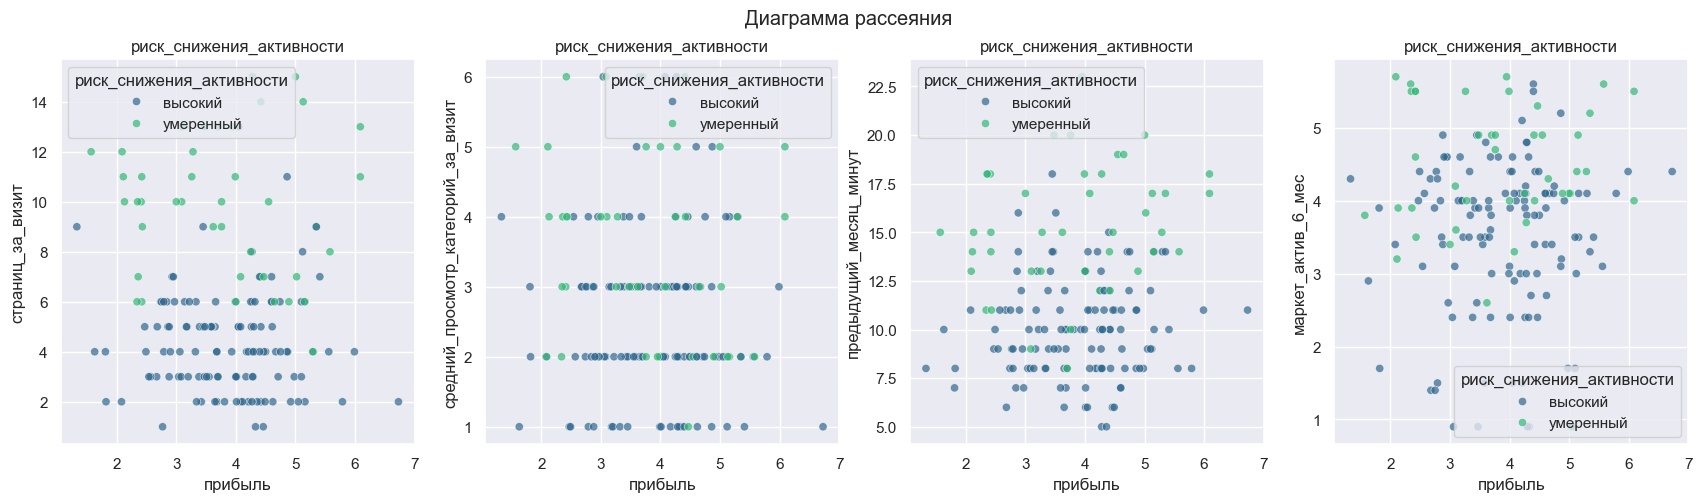

In [93]:
# категориальные данные, которые будем использовать для построения диаграмм рассеяния
hue = 'риск_снижения_активности'
features = ['страниц_за_визит', 'средний_просмотр_категорий_за_визит', 'предыдущий_месяц_минут', 'маркет_актив_6_мес']

# построение диаграмм рассеяния
def build_plot(x):
    fig, ax = plt.subplots(1, 4, figsize=(21, 5))
    fig.suptitle(f'Диаграмма рассеяния')

    for index, item in enumerate(features):
        scatterplot(ax=ax[index], x=x, y=item)
        ax[index].set_ylabel(item)
        plt.grid(True)
    plt.show()

# построение диаграммы рассеяния
def scatterplot(ax, x, y):
    sns.scatterplot(x=x, y=y, data=segment, hue=hue, palette='viridis', alpha=0.7, ax=ax)
    ax.set_title(hue)

build_plot(x='прибыль')

Были созданы 4 скатерплота для визуализации признаков для сегментации
- Страниц за визит: от 6 просмотренных страниц за визит снижается шанс "понижения активности"
- Средний просмотр категорий за визит: от 3 просмотренных категорий на сайте снижается шанс "понижения активности"
- Предыдущий месяц минут: от 14+ минут времени активности на сайте - ниже шанс "понижения активности" 
- Маркет актив 6 мес: сложно визуально выделить закономерность

### 8.2 Предложение по увеличению покупательской активность

1. Повысить время проведенное на сайте за счет предложения похожих товаров, дополнительных возможностей сравнения товаров, выбора дополнительных параметров товаров
1.1 Чтобы увеличить "Средний просмотр категорий" тоже нужно удерживать внимание покупателя на сайте
2. Выводить, сделать заметнее и чаще предлагать товары на акциях
3. Регулярно рассылать имейл рассылку не реже 3х раз в месяц
4. Работать над вовлечением человека на сайт, чтобы тот заходил чаще (рассылки, акции, дополнительные фичи)


### 8.3 Выводы о сегментe

Была взят сегмент покупателей, преимущественно заинтересованных в акционных сделках. Этот сегмент чувствителен к имейл рассылкам, к количеству акционных товаров, возможнно сезонности (праздничные рассылки, акции).
1. Выводы были сделаны на основе высоких корреляция между вероятностью снижения активности и следующими признаками: "Страниц за визит", "Средний просмотр категорий за визит", "Предыдущий месяц минут", "Маркет актив 6 мес".
2. Ключевые моменты: поддерживать высокую посещаемость страниц выше 6, от 3х просмотренных категорий, удерживать и увеличивать время на сайте выше 14 минут.

<a id="conclusion"></a> 
## 9. Общий вывод

Было разработано решение по персонализации предложений постоянным клиентам. Были предложены варианты для увеличения покупательской активности для выделенного сегмента пользователей.

Интернет магазину требовалось модель для определения признаков покупателей, которые могут понизить активность в будущем на основе их текущих данных. Определить и описать признаки, чтобы работа модели была понятной и ожидаемой.
Исходя из признаков сегментировать клиентов и выделить группу с наибольшей частотой покупки акционных товаров и потенциалом к снижению покупательской активности.

В исходных данных было 4 таблицы. 
- market_file.csv (Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.)
- market_money.csv (Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.)
- market_time.csv (Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.)
- money.csv (Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.)

Таблицы содержали ошибки и неоднородности. Всё было исправлено и подготовленно для последующего анализа.

Для эффективного анализа таже требовалось создать новые признаки и объединить таблицы.
- признаки содержащие данные о времени и месяцах были выделены в отдельные колонки

В поиск лучшей модели входило разработка пайплайна. Конечный результат содержал вариации для 4 моделей и их подходящих гиперпараметров.
- для поиска лучшей модели был использован RandomizedSearchCV класс
- после работы вывел оптимальную модель и ее гиперпараметры
- метрика для оценки качества модели была выбрана "ROC-AUC"

В ходе анализа лучшей моделью оказалась модель LogisticRegression(). Ее параметры:
- C=4, penalty='l1', random_state=42, solver='liblinear'
- Метрика модели на тренировочной выборке: 0.90
- Метрика ROC-AUC на тестовой выборке: 0.91

Был проведен Анализ важности признаков с использованием специальных инструментов и методики "SHAP". Результатом были:
- построены графики важности признаков
- визуализированы и отсортированы все признаки
- какие признаки мало значимы для модели: признаки перемножения "поп категория * пред мес мин", "тип сервиса * неоплач продукты штук", "популярная категория * страниц за визит", "тип сервиса * прдыдущий месяц мин", "предыдущий месяц выручка"
- сильнее всего влияют на целевой признак: Средний просмотр категорий за визит, страниц за визит, акционные покупки, предыдущий и текущий месяц минут
- Средний просмотр категорий за визит: Меньшее количество просмотров увеличивает шанс снижения активности.
- Страниц за визит: Меньшее количество страниц увеличивает шанс снижения активности.
- Акционные покупки: Большее количество акционных покупок повышает шанс снижения активности.

Проведения анализа важности признаков помог найти новые зависимости и распределить приоритеты для бизнес решений. Не все признаки самовыражены, но некоторые становятся сильнее с другими.



Для Сегментация покупателей были выделены признаки активности, прибыли и доля купленных акционных сделок.

- Для отдельного изучения были выбраны клиенты с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Результатами анализа и визуализации сегментации покупателей были:
1. построены 4 скаттерплота показывающих распределение зависимости важных признаков от "Риска снижения активности"
2. были выявлены закономерности о длительности нахождения на странице, просмотр категорий за визит, количества просмотренных страниц и количества полученных имейл рассылок
3. исходя из этого было предложено: поддерживать высокую посещаемость страниц выше 6, удерживать и увеличивать время на сайте выше 14 минут, средний просмотр категорий от 3х.
4. этот сегмент чувствителен к имейл рассылкам, к количеству акционных товаров, возможнно сезонности (праздничные рассылки, акции).
